In [7]:
!pip install matplotlib pandas requests numpy tqdm qrcode


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [8]:
import collections
import datetime
import os
import time

import numpy as np
import pandas as pd
import requests
import qrcode
import qrcode.image.svg

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

print(plt.style.available)
# plt.style.use('seaborn-v0_8-colorblind')  # paper figures
plt.style.use('seaborn-v0_8-poster')  # poster figures

plt.rcParams.update({'font.size': 14})

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [9]:
# configs
from configs import base_results_folder, datetime_format, hpa_data, prometheus_endpoint

# get latest folder:
latest_folder = None
for f in sorted(os.listdir(os.path.join(base_results_folder))):
    if os.path.isdir(os.path.join(base_results_folder, f)) and f != "figures":
        print(f)
        latest_folder = f

# latest_folder = "jocn_20221204T093831.502593UTC"  # stable results from Sunda
# latest_folder = "jocn_20230129T160117.267710UTC"  # folder from revision
latest_folder = "jocn_20230131T082259.657842UTC"

start_experiment = time.mktime(datetime.datetime(2023, 1, 29, 16, 9, 0).timetuple()),
end_experiment = time.mktime(datetime.datetime(2023, 1, 29, 21, 15, 0).timetuple()),

os.makedirs(os.path.join(base_results_folder, latest_folder, "figures"), exist_ok=True)

jocn_20221204T093831.502593UTC
jocn_20230129T160117.267710UTC
jocn_20230131T082259.657842UTC
jocn_20230222T055227.218793UTC


In [10]:
img = qrcode.make('https://tfs.etsi.org/', image_factory=qrcode.image.svg.SvgImage)

with open('results/etsi-qr.svg', 'wb') as qr:
    img.save(qr)

In [11]:
# loading hpa names
hpas = []
with open(os.path.join(base_results_folder, latest_folder, "hpas.csv"), "rt", encoding="utf-8") as file:
    for line in file.readlines():
        hpas.append(line.replace("\n", ""))
print(hpas)

['opticalattackmitigatorservice-hpa', 'dbscanservingservice-hpa', 'opticalattackdetectorservice-hpa']


In [12]:
# https://stackoverflow.com/questions/12522963/converters-for-python-pandas
def convert_cpu_usage(value):
    # u -> / 1_000
    # n -> / 1_000_000
    if len(value) == 0:
        return float('nan')
    if value.endswith("u"):
        return float(value.replace("u", "")) * 1_000
    elif value.endswith("n"):
        return float(value.replace("n", "")) * 1_000_000
    else:
        raise ValueError(f"Error converting {value} to mCPUs")

def convert_memory_usage(value):
    if len(value) == 0:
        return float('nan')
    if value.endswith("Mi"):
        return float(value.replace("Mi", "")) * 1_000
    elif value.endswith("Ki"):
        return float(value.replace("Ki", ""))
    else:
        raise ValueError(f"Error converting {value} to Ki")

number_services = pd.read_csv(
    os.path.join(base_results_folder, latest_folder, "services.csv"), skiprows=1,
    converters={
        "cache_cpu": convert_cpu_usage, "manager_cpu": convert_cpu_usage,
        "cache_ram": convert_memory_usage, "manager_ram": convert_memory_usage,
    }
)
number_services["timestamp"] = pd.to_datetime(number_services["timestamp"], format=datetime_format)
earliest_sample = number_services["timestamp"].sort_values()[0]

# number_services["seconds"] = []

number_services["seconds"] = number_services.apply(lambda row: (row["timestamp"] - earliest_sample).total_seconds(), axis=1)

number_services.tail()

,timestamp,number_services,opticalattackmitigatorservice-hpa_cur_utilization,opticalattackmitigatorservice-hpa_target_utilization,opticalattackmitigatorservice-hpa_cur_replicas,opticalattackmitigatorservice-hpa_desired_replicas,dbscanservingservice-hpa_cur_utilization,dbscanservingservice-hpa_target_utilization,dbscanservingservice-hpa_cur_replicas,dbscanservingservice-hpa_desired_replicas,opticalattackdetectorservice-hpa_cur_utilization,opticalattackdetectorservice-hpa_target_utilization,opticalattackdetectorservice-hpa_cur_replicas,opticalattackdetectorservice-hpa_desired_replicas,cache_cpu,cache_ram,manager_cpu,manager_ram,seconds
115,2023-01-31 14:13:01,0,2,80,2,2,1,80,2,2,2,80,2,2,3.688660e+11,757220.0,2.569470e+11,4752.0,17103.0
116,2023-01-31 14:18:00,0,2,80,2,2,1,80,2,2,2,80,2,2,NaN,NaN,NaN,NaN,17402.0
117,2023-01-31 14:18:01,0,2,80,2,2,1,80,2,2,2,80,2,2,4.050550e+11,757448.0,3.544610e+11,4752.0,17403.0
118,2023-01-31 14:23:00,0,1,80,2,2,2,80,2,2,2,80,2,2,NaN,NaN,NaN,NaN,17702.0
119,2023-01-31 14:23:01,10,1,80,2,2,2,80,2,2,2,80,2,2,4.055380e+11,757448.0,5.106052e+12,40888.0,17703.0


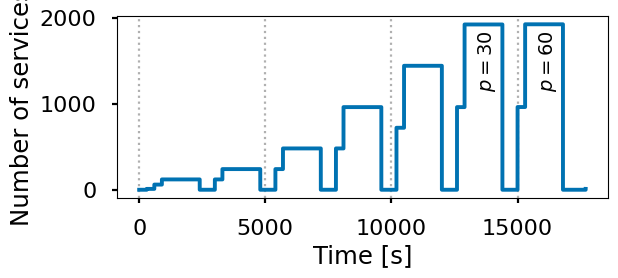

In [13]:
# last_sample = 97
last_sample = len(number_services["seconds"])

plt.figure(figsize=(6.4, 3.))
plt.grid(axis="x", ls=":")
plt.plot(number_services["seconds"][:last_sample], number_services["number_services"][:last_sample])

plt.text(13800, 1500, r"$p=30$", rotation=90, verticalalignment="center", horizontalalignment="center")
plt.text(16200, 1500, r"$p=60$", rotation=90, verticalalignment="center", horizontalalignment="center")

plt.xlabel("Time [s]")
plt.ylabel("Number of services")

plt.tight_layout()
plt.savefig(os.path.join(base_results_folder, latest_folder, "figures", "number_services.pdf"))
plt.show()

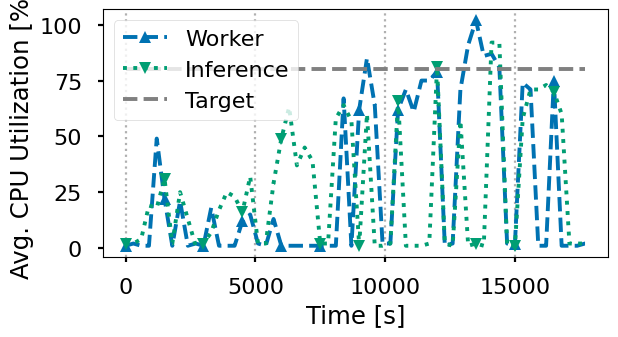

In [14]:
plt.figure(figsize=(6.4, 3.6))

plt.grid(axis="x", ls=":")

hpa = hpas[1]
plt.plot(number_services["seconds"], number_services[f"{hpa}_cur_utilization"], label="Worker", marker="^", ls="--", markersize=8, markevery=10, markeredgecolor="white")

hpa = hpas[2]
plt.plot(number_services["seconds"], number_services[f"{hpa}_cur_utilization"], label="Inference", ls=":", marker="v", markersize=8, markevery=10, markeredgecolor="white")

plt.plot(number_services["seconds"][:last_sample], number_services[f"{hpa}_target_utilization"][:last_sample], ls="--", color="gray", label="Target")

plt.xlabel("Time [s]")
plt.ylabel("Avg. CPU Utilization [%]")
plt.legend(loc=2)

plt.tight_layout()
plt.savefig(os.path.join(base_results_folder, latest_folder, "figures", f"monitoring_hpa_cpu.pdf"))
plt.show()

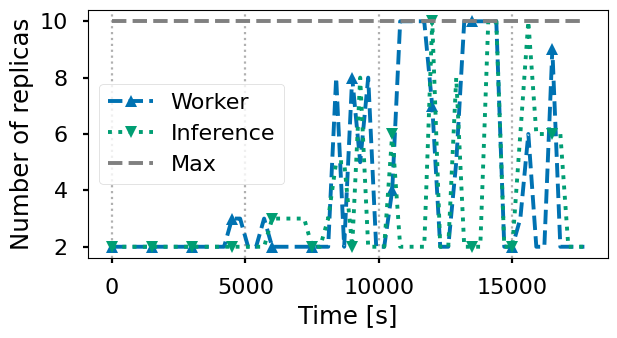

In [15]:
plt.figure(figsize=(6.4, 3.6))

plt.grid(axis="x", ls=":")

# plt.plot(number_services["seconds"][:last_sample], [2 for x in range(len(number_services["seconds"]))][:last_sample], ls="--", color="gray")

hpa = hpas[1]
plt.plot(number_services["seconds"], number_services[f"{hpa}_cur_replicas"], label="Worker", marker="^", ls="--", markersize=8, markevery=10, markeredgecolor="white")

hpa = hpas[2]
plt.plot(number_services["seconds"], number_services[f"{hpa}_cur_replicas"], label="Inference", ls=":", marker="v", markersize=8, markevery=10, markeredgecolor="white")

plt.plot(number_services["seconds"][:last_sample], [10 for x in range(len(number_services["seconds"]))][:last_sample], ls="--", color="gray", label="Max")

plt.xlabel("Time [s]")
plt.ylabel("Number of replicas")
plt.legend(loc=6)

plt.tight_layout()
plt.savefig(os.path.join(base_results_folder, latest_folder, "figures", f"monitoring_hpa_replicas.pdf"))
plt.show()

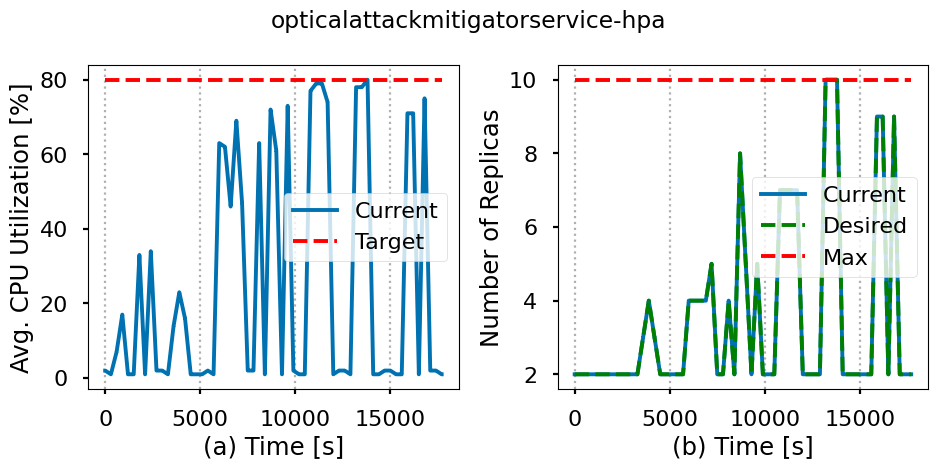

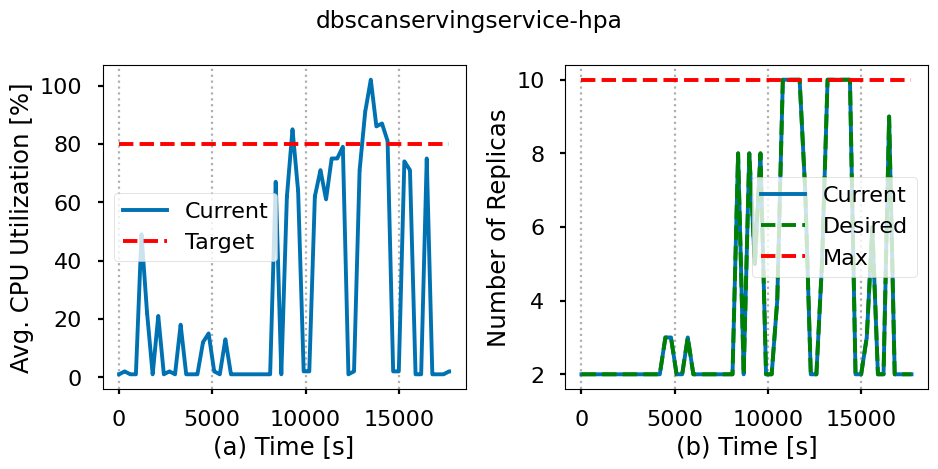

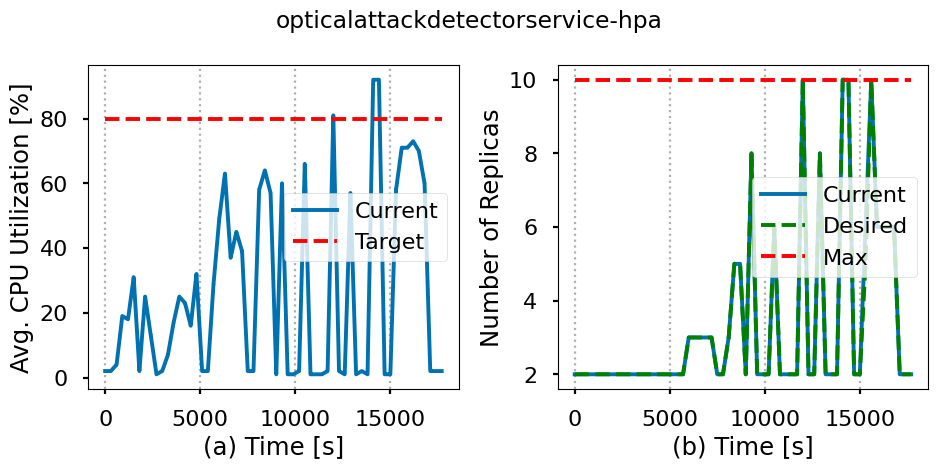

In [16]:
for hpa in hpas:
    # - "cur_utilization"
    # - "target_utilization"
    # - "cur_replicas"
    # - "desired_replicas"

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9.6, 4.8))
    fig.suptitle(hpa)

    ax1.grid(axis="x", ls=":")
    ax1.plot(number_services["seconds"][:last_sample], number_services[f"{hpa}_cur_utilization"][:last_sample], label="Current")
    ax1.plot(number_services["seconds"][:last_sample], number_services[f"{hpa}_target_utilization"][:last_sample], ls="--", color="red", label="Target")
    ax1.set_xlabel("(a) Time [s]")
    ax1.set_ylabel("Avg. CPU Utilization [%]")
    ax1.legend()

    ax2.grid(axis="x", ls=":")
    ax2.plot(number_services["seconds"][:last_sample], number_services[f"{hpa}_cur_replicas"][:last_sample], label="Current")
    ax2.plot(number_services["seconds"][:last_sample], number_services[f"{hpa}_desired_replicas"][:last_sample], ls="--", color="green", label="Desired")
    ax2.plot(number_services["seconds"][:last_sample], [10 for x in range(len(number_services["seconds"]))][:last_sample], ls="--", color="red", label="Max")
    ax2.set_xlabel("(b) Time [s]")
    ax2.set_ylabel("Number of Replicas")
    ax2.legend(loc=7)

    plt.tight_layout()
    plt.savefig(os.path.join(base_results_folder, latest_folder, "figures", f"monitoring_{hpa}.pdf"))
    plt.show()

/tmp/ipykernel_2397991/1239110600.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  axs[i].plot(resources["seconds"][:last_sample], resources[f"{s}_{k}"] / 1_000, label="Current")


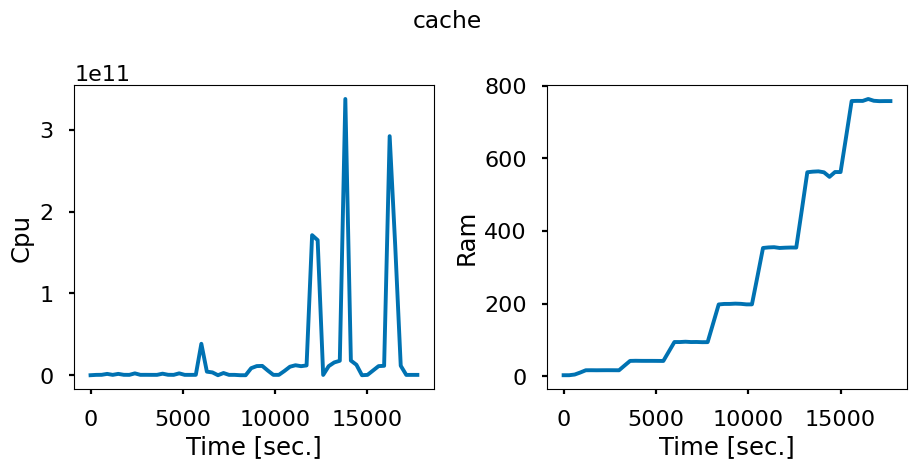

/tmp/ipykernel_2397991/1239110600.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  axs[i].plot(resources["seconds"][:last_sample], resources[f"{s}_{k}"] / 1_000, label="Current")


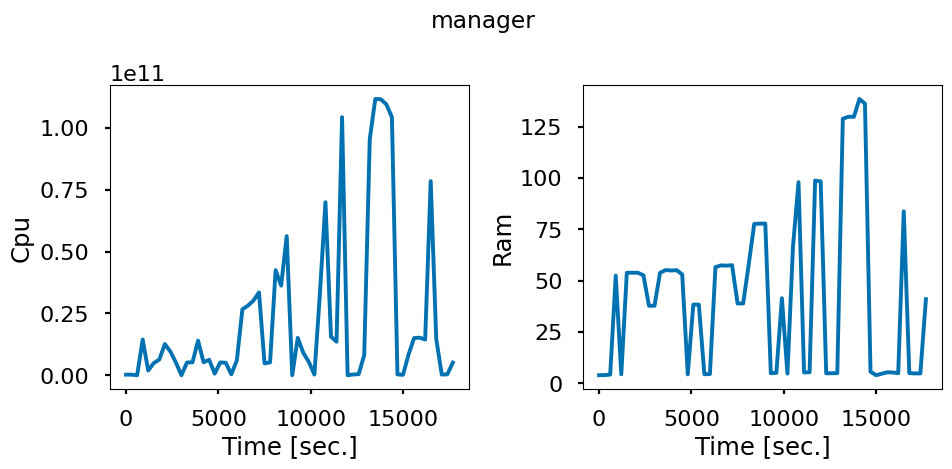

In [17]:
# monitoring CPU and RAM usage of the single Pods
resources = number_services.dropna()
for s in ["cache", "manager"]:
    fig, axs = plt.subplots(1, 2, figsize=(9.6, 4.8))
    plt.suptitle(s)
    for i, k in enumerate(["cpu", "ram"]):
        axs[i].plot(resources["seconds"][:last_sample], resources[f"{s}_{k}"] / 1_000, label="Current")
        axs[i].set_xlabel("Time [sec.]")
        axs[i].set_ylabel(k.capitalize())
    plt.tight_layout()
    plt.savefig(os.path.join(base_results_folder, latest_folder, "figures", f"resources_{s}.pdf"))
    plt.show()

## Getting data from Prometheus

In [18]:
# define period
yesterday = datetime.date.today() - datetime.timedelta(days=1)
duration = '[' + str(yesterday.day) + 'd]'

results values: {'status': 'success', 'data': {'resultType': 'matrix', 'result': [{'metric': {'__name__': 'optical_security_active_services', 'instance': '10.1.19.194:9192', 'job': 'opticalattackmanagerservice'}, 'values': [[1675004940, '720'], [1675005008, '720'], [1675005076, '720'], [1675005144, '720'], [1675005212, '1440'], [1675005280, '1440'], [1675005348, '1440'], [1675005416, '1440'], [1675005484, '1440'], [1675005552, '1440'], [1675005620, '1440'], [1675005688, '1440'], [1675005756, '1440'], [1675005824, '1440'], [1675005892, '1440'], [1675005960, '1440'], [1675006028, '1440'], [1675006096, '1440'], [1675006164, '1440'], [1675006232, '1440'], [1675006300, '1440'], [1675006368, '1440'], [1675006436, '1440'], [1675006504, '1440'], [1675006572, '1440'], [1675006640, '1440'], [1675006708, '0'], [1675006776, '0'], [1675006844, '0'], [1675006912, '0'], [1675006980, '0'], [1675007048, '0'], [1675007116, '0'], [1675007252, '120'], [1675007320, '480']]}, {'metric': {'__name__': 'optica

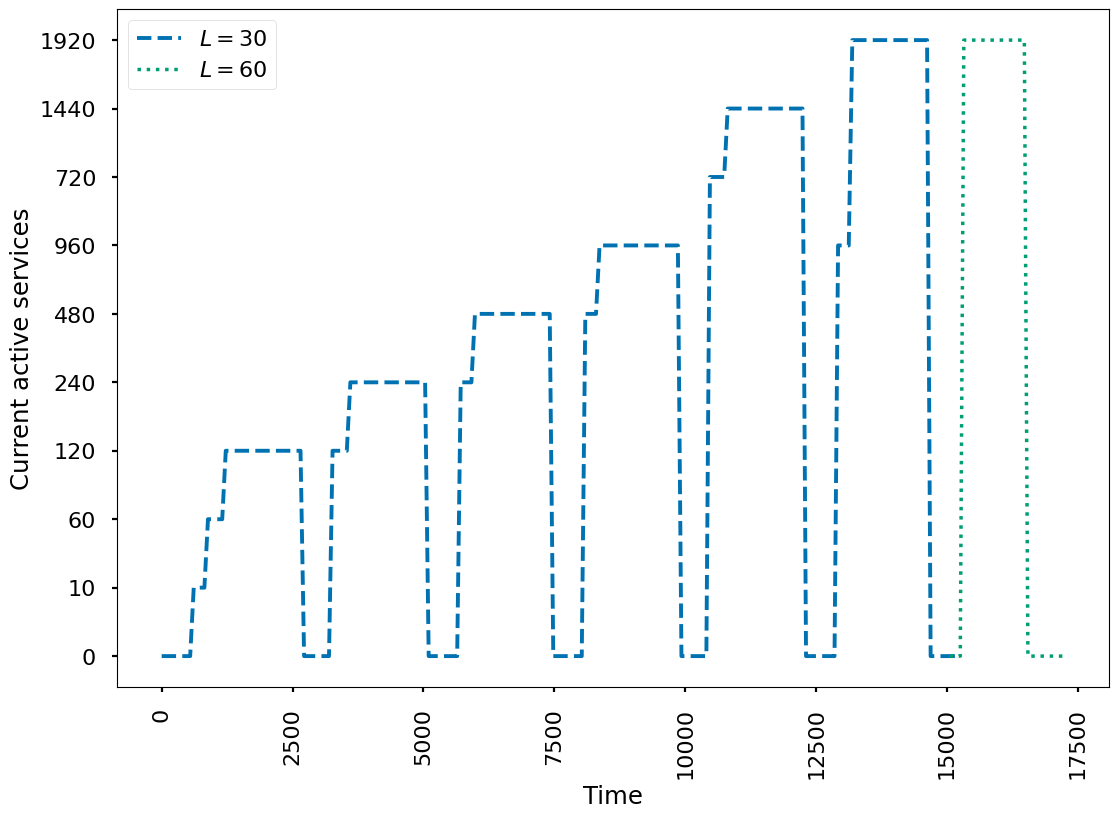

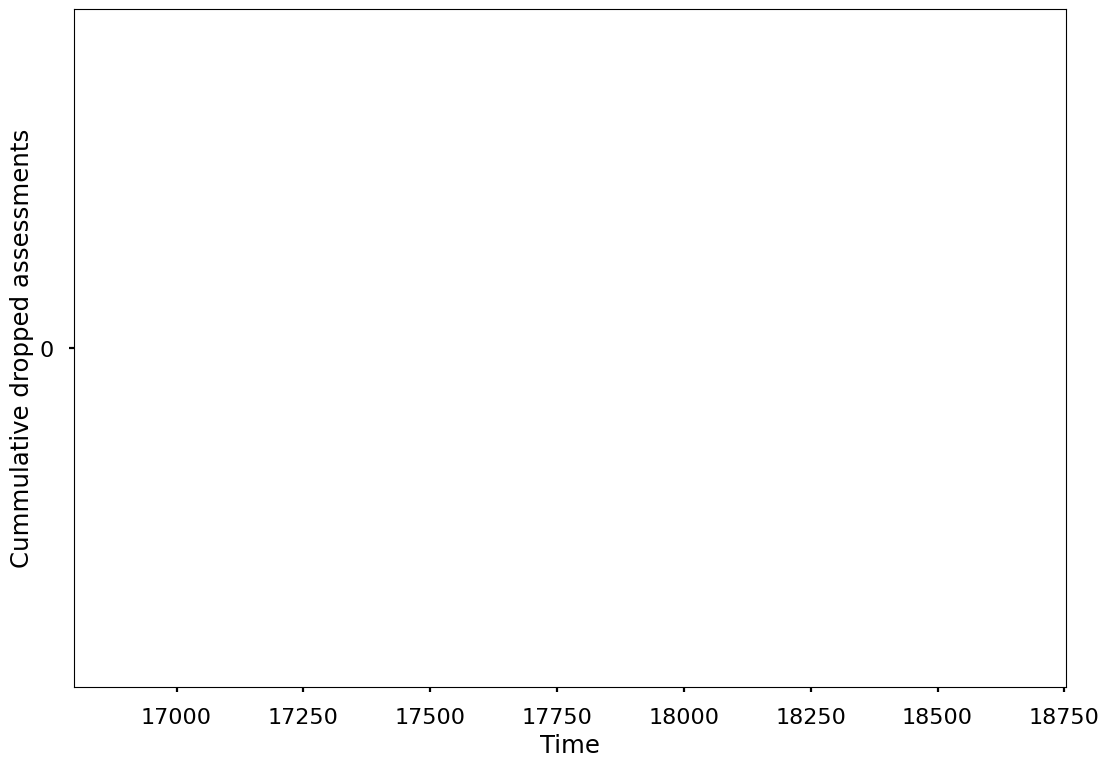

In [20]:
# http://localhost:9090/api/v1/query_range?query=optical_security_active_services&start=1670203354&end=1670217754&step=57
# http://localhost:9090/api/v1/query_range?query=optical_security_active_services&start=1670202754&end=1670217754&step=60

response = requests.get(
    f"{prometheus_endpoint}/api/v1/query_range",
    params={
        "query": f"optical_security_active_services",
        # "start": 1675008354,
        # "end": 1675025454,
        "start": start_experiment,
        "end": end_experiment,
        "step": 68,
        # "time": time.mktime(yesterday.timetuple())
    }
)
parsed_services = response.json()

response = requests.get(
    f"{prometheus_endpoint}/api/v1/query_range",
    params={
        "query": f"optical_security_dropped_assessments_total",
        # "start": 1670202754,
        # "end": 1670217754,
        "start": time.mktime(datetime.datetime(2023, 1, 29, 16, 9, 0).timetuple()),
        "end": time.mktime(datetime.datetime(2023, 1, 29, 21, 15, 0).timetuple()),
        "step" :60,
        # "time": time.mktime(yesterday.timetuple())
    }
)
parsed_dropped = response.json()

print("results values:", parsed_services)

initial_timestamp = parsed_services["data"]["result"][3]["values"][0][0]
initial_datetime = datetime.datetime.fromtimestamp(initial_timestamp)

x_values = []
y_values_active_services = []
y_values_dropped_services = []

for value_services in parsed_services["data"]["result"][3]["values"]:
    parsed_date = datetime.datetime.fromtimestamp(value_services[0])
    x_values.append((parsed_date - initial_datetime).total_seconds())
    # x_values.append(time.gmtime(value_services[0]))
    # x_values.append(float(value_services[0]))

    y_values_active_services.append(value_services[1])

    # uncomment to check timestamps
    # print(time.gmtime(float(value_services[0])), float(value_services[1]))
    print(float(value_services[0]), float(value_services[1]))

plt.figure()
plt.plot(x_values, y_values_active_services, label=r"$L=30$", ls="--")

x_values = []
y_values_active_services = []
response = requests.get(
    f"{prometheus_endpoint}/api/v1/query_range",
    params={
        "query": f"optical_security_active_services",
        # "start": 1675008354,
        # "end": 1675025454,
        "start": time.mktime(datetime.datetime(2023, 1, 29, 21, 20, 0).timetuple()),
        "end": time.mktime(datetime.datetime(2023, 1, 29, 21, 59, 0).timetuple()),
        "step": 68,
        # "time": time.mktime(yesterday.timetuple())
    }
)
parsed_services = response.json()
for value_services in parsed_services["data"]["result"][0]["values"]:
    parsed_date = datetime.datetime.fromtimestamp(value_services[0])
    x_values.append((parsed_date - initial_datetime).total_seconds()-550)
    # x_values.append(time.gmtime(value_services[0]))
    # x_values.append(float(value_services[0]))

    x = value_services[1]
    if float(x) == 1921.:
        x = 1920
    y_values_active_services.append(x)

    # uncomment to check timestamps
    # print(time.gmtime(float(value_services[0])), float(value_services[1]))
    print(float(value_services[0]), float(value_services[1]))

plt.plot(x_values, y_values_active_services, label=r"$L=60$", ls=":", linewidth=2.5)
plt.xlabel("Time")
plt.ylabel("Current active services")
plt.legend(loc=2)
plt.tick_params(axis="x", rotation=90)
# plt.grid()
# plt.ticklabel_format(style="plain")
# plt.gca().set_xticklabels(rotation=90)

plt.show()
plt.close()

x_values = []
for value_dropped in parsed_dropped["data"]["result"][0]["values"]:
    parsed_date = datetime.datetime.fromtimestamp(value_services[0])
    x_values.append((parsed_date - initial_datetime).total_seconds())
    # x_values.append(float(value_services[0]))

    y_values_dropped_services.append(value_dropped[1])

    # uncomment to check timestamps
    # print(y_values_dropped_services[-1], float(value_services[0]))

plt.figure()
plt.plot(x_values, y_values_dropped_services)

plt.xlabel("Time")
plt.ylabel("Cummulative dropped assessments")
plt.show()
plt.close()

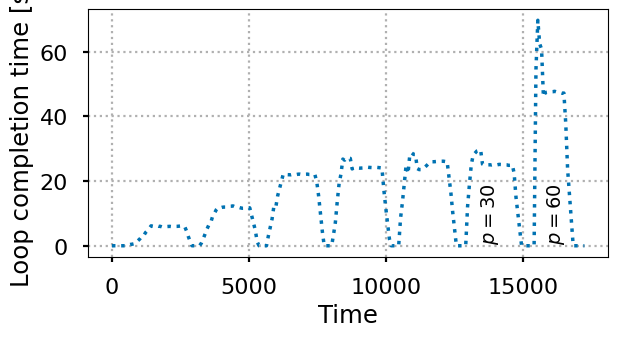

In [21]:
# http://localhost:9090/api/v1/query_range?query=optical_security_active_services&start=1670203354&end=1670217754&step=57
# http://localhost:9090/api/v1/query_range?query=optical_security_active_services&start=1670202754&end=1670217754&step=60

query = "rate(optical_security_loop_seconds_sum[5m]) / rate(optical_security_loop_seconds_count[5m])"

response = requests.get(
    f"{prometheus_endpoint}/api/v1/query_range",
    params={
        "query": query,
        # "start": 1675008354,
        # "end": 1675025454,
        "start": time.mktime(datetime.datetime(2023, 1, 29, 16, 9, 0).timetuple()),
        "end": time.mktime(datetime.datetime(2023, 1, 29, 21, 15, 0).timetuple()),
        "step": 68,
        # "time": time.mktime(yesterday.timetuple())
    }
)
parsed_services = response.json()

# print("results values:", parsed_services)

initial_timestamp = parsed_services["data"]["result"][3]["values"][0][0]
initial_datetime = datetime.datetime.fromtimestamp(initial_timestamp)

x_values = []
y_values_active_services = []

for value_services in parsed_services["data"]["result"][3]["values"]:
    parsed_date = datetime.datetime.fromtimestamp(value_services[0])
    x_values.append((parsed_date - initial_datetime).total_seconds())
    # x_values.append(time.gmtime(value_services[0]))
    # x_values.append(float(value_services[0]))

    y_values_active_services.append(float(value_services[1]))

    # uncomment to check timestamps
    # print(time.gmtime(float(value_services[0])), float(value_services[1]))
    # print(float(value_services[0]), float(value_services[1]))

plt.figure(figsize=(6.4, 3.6))
# plt.plot(x_values, y_values_active_services, label=r"$L=30$", ls="--")

# x_values = []
# y_values_active_services = []
response = requests.get(
    f"{prometheus_endpoint}/api/v1/query_range",
    params={
        "query": query,
        # "start": 1675008354,
        # "end": 1675025454,
        "start": time.mktime(datetime.datetime(2023, 1, 29, 21, 25, 0).timetuple()),
        "end": time.mktime(datetime.datetime(2023, 1, 29, 21, 59, 0).timetuple()),
        "step": 68,
        # "time": time.mktime(yesterday.timetuple())
    }
)
parsed_services = response.json()
for value_services in parsed_services["data"]["result"][0]["values"]:
    parsed_date = datetime.datetime.fromtimestamp(value_services[0])
    x_values.append((parsed_date - initial_datetime).total_seconds()-550)
    # x_values.append(time.gmtime(value_services[0]))
    # x_values.append(float(value_services[0]))

    y_values_active_services.append(float(value_services[1]))

    # uncomment to check timestamps
    # print(time.gmtime(float(value_services[0])), float(value_services[1]))
    # print(float(value_services[0]), float(value_services[1]))

# print(x_values, y_values_active_services)
plt.plot(x_values, y_values_active_services, label=r"$L=60$", ls=":", linewidth=2.5)

plt.text(13800, 10, r"$p=30$", rotation=90, verticalalignment="center", horizontalalignment="center")
plt.text(16200, 10, r"$p=60$", rotation=90, verticalalignment="center", horizontalalignment="center")

plt.xlabel("Time")
plt.ylabel("Loop completion time [s]")
# plt.legend(loc=2)
# plt.tick_params(axis="x", rotation=90)
# plt.grid()
# plt.ticklabel_format(style="plain")
# plt.gca().set_xticklabels(rotation=90)
plt.grid(axis="both", ls=":")
plt.tight_layout()

plt.savefig(os.path.join(base_results_folder, latest_folder, "figures", f"loop_completion_time.pdf"))

plt.show()
plt.close()

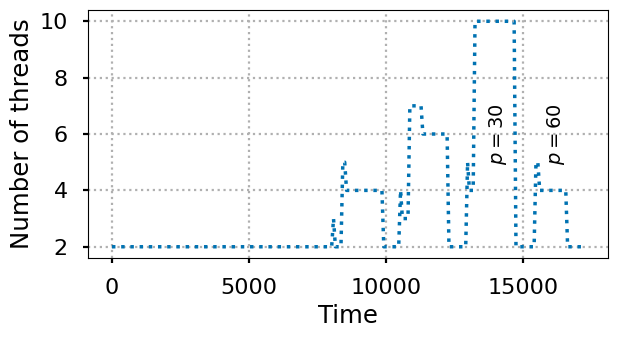

In [22]:
# http://localhost:9090/api/v1/query_range?query=optical_security_active_services&start=1670203354&end=1670217754&step=57
# http://localhost:9090/api/v1/query_range?query=optical_security_active_services&start=1670202754&end=1670217754&step=60

query = "optical_security_number_workers"

response = requests.get(
    f"{prometheus_endpoint}/api/v1/query_range",
    params={
        "query": query,
        # "start": 1675008354,
        # "end": 1675025454,
        "start": time.mktime(datetime.datetime(2023, 1, 29, 16, 9, 0).timetuple()),
        "end": time.mktime(datetime.datetime(2023, 1, 29, 21, 15, 0).timetuple()),
        "step": 68,
        # "time": time.mktime(yesterday.timetuple())
    }
)
parsed_services = response.json()

# print("results values:", parsed_services)

initial_timestamp = parsed_services["data"]["result"][3]["values"][0][0]
initial_datetime = datetime.datetime.fromtimestamp(initial_timestamp)

x_values = []
y_values_active_services = []

for value_services in parsed_services["data"]["result"][3]["values"]:
    parsed_date = datetime.datetime.fromtimestamp(value_services[0])
    x_values.append((parsed_date - initial_datetime).total_seconds())
    # x_values.append(time.gmtime(value_services[0]))
    # x_values.append(float(value_services[0]))

    y_values_active_services.append(float(value_services[1]))

    # uncomment to check timestamps
    # print(time.gmtime(float(value_services[0])), float(value_services[1]))
    # print(float(value_services[0]), float(value_services[1]))

plt.figure(figsize=(6.4, 3.6))
# plt.plot(x_values, y_values_active_services, label=r"$L=30$", ls="--")

# x_values = []
# y_values_active_services = []
response = requests.get(
    f"{prometheus_endpoint}/api/v1/query_range",
    params={
        "query": query,
        # "start": 1675008354,
        # "end": 1675025454,
        "start": time.mktime(datetime.datetime(2023, 1, 29, 21, 25, 0).timetuple()),
        "end": time.mktime(datetime.datetime(2023, 1, 29, 21, 59, 0).timetuple()),
        "step": 68,
        # "time": time.mktime(yesterday.timetuple())
    }
)
parsed_services = response.json()
for value_services in parsed_services["data"]["result"][0]["values"]:
    parsed_date = datetime.datetime.fromtimestamp(value_services[0])
    x_values.append((parsed_date - initial_datetime).total_seconds()-550)
    # x_values.append(time.gmtime(value_services[0]))
    # x_values.append(float(value_services[0]))

    y_values_active_services.append(float(value_services[1]))

    # uncomment to check timestamps
    # print(time.gmtime(float(value_services[0])), float(value_services[1]))
    # print(float(value_services[0]), float(value_services[1]))

# print(x_values, y_values_active_services)
plt.plot(x_values, y_values_active_services, label=r"$L=60$", ls=":", linewidth=2.5)

plt.text(14100, 6, r"$p=30$", rotation=90, verticalalignment="center", horizontalalignment="center")
plt.text(16200, 6, r"$p=60$", rotation=90, verticalalignment="center", horizontalalignment="center")

plt.xlabel("Time")
plt.ylabel("Number of threads")
# plt.legend(loc=2)
# plt.tick_params(axis="x", rotation=90)
# plt.grid()
# plt.ticklabel_format(style="plain")
# plt.gca().set_xticklabels(rotation=90)
plt.grid(axis="both", ls=":")
plt.tight_layout()

plt.savefig(os.path.join(base_results_folder, latest_folder, "figures", f"number_threads_manager.pdf"))

plt.show()
plt.close()

In [23]:
cur_duration = "[5m]"
loads = [120, 240, 480, 960, 1440, 1920, 1920]
times_services = (
    (1675009360.0, 1675010788.0),  # 120
    (1675011808.0, 1675013168.0),  # 240
    (1675014188.0, 1675015548.0),  # 480
    (1675016568.0, 1675017996.0),  # 960
    (1675019016.0, 1675020376.0),  # 1440
    (1675021396.0, 1675022756.0),  # 1920
    (1675024076.0, 1675025164.0),  # 1921
)

# response = requests.get(
#     f"{prometheus_endpoint}/api/v1/query",
#     params={
#         "query": f"rate(optical_security_loop_seconds_sum{cur_duration}) / rate(optical_security_loop_seconds_count{cur_duration})",
#         # "time": time.mktime(yesterday.timetuple())
#         # "range_input": "1h",
#     }
# )
# print(response.content)
# parsed = response.json()

# print("results values:", parsed["data"]["result"])

# initial_timestamp = parsed["data"]["result"][0]["value"][0]
# initial_datetime = datetime.datetime.fromtimestamp(initial_timestamp)


# x_values = []
# y_values = []

# for series in parsed["data"]["result"]:
#     for value in series["value"]:
#         parsed_date = datetime.datetime.fromtimestamp(value)
#         x_values.append((parsed_date - initial_datetime).total_seconds())

#         y_values.append(value_services[

KeyError: inf

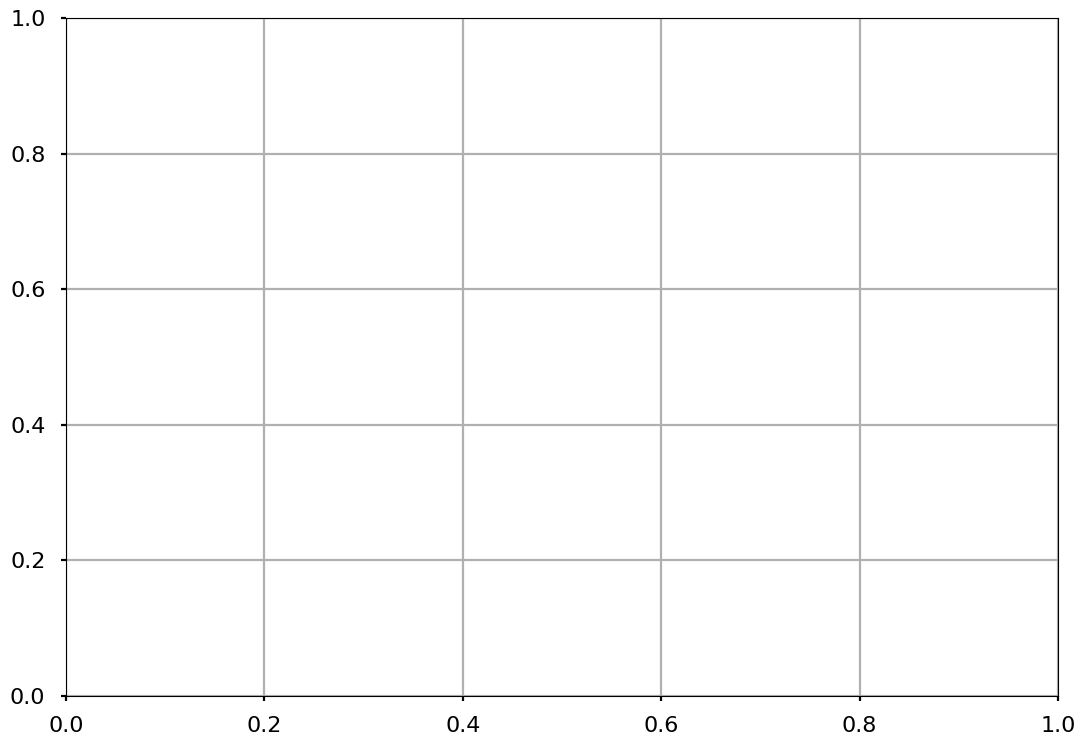

In [24]:
yesterday = datetime.date.today() # - datetime.timedelta(days=1)
duration = '[' + str(yesterday.day) + 'd]'

metrics = (
    # "optical_security_loop_seconds_bucket",
    "DbscanServing_Detect_histogram_duration_bucket",
    # "OpticalAttackDetector_DetectAttack_histogram_duration_bucket",
    # "OPTICAL_ATTACK_DETECTOR_CACHE_RESPONSE_TIME_histogram_duration_bucket",
    # "OPTICAL_ATTACK_DETECTOR_INFERENCE_RESPONSE_TIME_histogram_duration_bucket",
)

curves_specific_load = {}

for prom_metric in metrics:
    response = requests.get(
        f"{prometheus_endpoint}/api/v1/query",
        params={
            "query": f"{prom_metric}{duration}",
            "range_input": "4h10m",
            "end_input": "2022-12-05 05:22:34",
        }
    )

    parsed = response.json()

    cdf = {}
    for load in loads:
        cdf[load] = {}
    
    for metric in parsed["data"]["result"]:
        for load, _time in zip(loads, times_services):
            if float(metric["metric"]["le"]) not in cdf[load]:
                cdf[load][float(metric["metric"]["le"])] = []
                # print(metric["metric"])
            for value in metric["values"]:
                # if _time[0] < value[0] and value[0] < _time[1]:
                # print(load, metric["metric"]["le"], value)
                cdf[load][float(metric["metric"]["le"])].append(float(value[1]))
                # break # stops the loop over values when the first one is found
        # print("\tmetric:", metric["metric"]["le"], type(metric["metric"]["le"]))
        # print("\tvalue:", metric["values"])
    
    # defining the minimum and maximum x
    min_x = 0
    max_x = len(cdf[load].keys()) - 1

    plt.figure()
    plt.grid()
    # plt.title(prom_metric)
    for load in loads:
        diff = 0
        probabilities = np.zeros((len(cdf[load].keys()),))
        i = 0
        for key in sorted(cdf[load].keys()):
            if cdf[load][key] == float('Inf'):
                continue
            # if i == 0 and prom_metric == "optical_security_loop_seconds_bucket":
            #     diff = np.mean(cdf[load][key])
            # print(i, key)
            # probabilities[i] = np.mean(cdf[load][key]) - diff

            # find lowest x
            # if i > 1 and probabilities[i-1] == 0 and probabilities[i] > 0:
            #     min_x = i - 2
            
            # # find highest x
            # if i > 0 and i - 1 < len(cdf[load].keys()) \
            #     and probabilities[i] > probabilities[i-1] \
            #     and prom_metric != "optical_security_loop_seconds_bucket":
            #     max_x = i - 1
            
            i += 1

        probabilities[i-1] = np.mean(cdf[load][float('Inf')])

        probabilities = probabilities / probabilities.max()

        if load == 480:
            curves_specific_load[prom_metric] = probabilities.copy()
        
        plt.plot(range(len(cdf[load].keys())), probabilities, label=load)

    plt.xticks(range(len(cdf[load].keys())), [x for x in sorted(cdf[load].keys()) if x != float("Inf")] + ["Inf"], rotation=90)
    plt.xlabel("Completion time [seconds]")
    plt.ylabel("CDF")
    plt.xlim([min_x - 0.25, max_x + 0.25])
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(base_results_folder, latest_folder, "figures", f"cdf_{prom_metric}.pdf"))
    plt.show()
    plt.close()


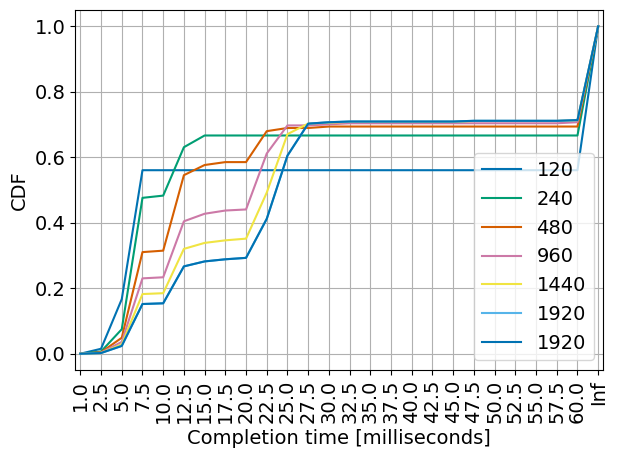

In [ ]:
yesterday = datetime.date.today() # - datetime.timedelta(days=1)
duration = '[' + str(yesterday.day) + 'd]'

metrics = (
    "optical_security_loop_seconds_bucket",
    # "DbscanServing_Detect_histogram_duration_bucket",
    # "OpticalAttackDetector_DetectAttack_histogram_duration_bucket",
    # "OPTICAL_ATTACK_DETECTOR_CACHE_RESPONSE_TIME_histogram_duration_bucket",
    # "OPTICAL_ATTACK_DETECTOR_INFERENCE_RESPONSE_TIME_histogram_duration_bucket",
)

for prom_metric in metrics:
    response = requests.get(
        f"{prometheus_endpoint}/api/v1/query_range",
        params={
            "query": f"{prom_metric}",
            "start": time.mktime(datetime.datetime(2023, 1, 29, 16, 9, 0).timetuple()),
            "end": time.mktime(datetime.datetime(2023, 1, 29, 21, 15, 0).timetuple()),
            # "start": 1670202754,
            # "end": 1670217754,
            "step" :60,
        }
    )

    parsed = response.json()
    # print(parsed)

    cdf = {}
    for load in loads:
        cdf[load] = {}
    
    for metric in parsed["data"]["result"]:
        for load, _time in zip(loads, times_services):
            if float(metric["metric"]["le"]) not in cdf[load]:
                cdf[load][float(metric["metric"]["le"])] = []
                # print(metric["metric"])
            for value in metric["values"]:
                if _time[0] < value[0] and value[0] < _time[1]:
                    # print(load, metric["metric"]["le"], value)
                    cdf[load][float(metric["metric"]["le"])].append(float(value[1]))
                    # break # stops the loop over values when the first one is found
        # print("\tmetric:", metric["metric"]["le"], type(metric["metric"]["le"]))
        # print("\tvalue:", metric["values"])
    
    # defining the minimum and maximum x
    min_x = 0
    max_x = len(cdf[load].keys()) - 1

    plt.figure()
    plt.grid()
    # plt.title(prom_metric)
    for load in loads:
        diff = 0
        probabilities = np.zeros((len(cdf[load].keys()),))
        i = 0
        for key in sorted(cdf[load].keys()):
            if cdf[load][key] == float('Inf'):
                continue
            if i == 0 and prom_metric == "optical_security_loop_seconds_bucket":
                diff = np.mean(cdf[load][key])
            # print(i, key)
            probabilities[i] = np.mean(cdf[load][key]) - diff

            # find lowest x
            if i > 1 and probabilities[i-1] == 0 and probabilities[i] > 0:
                min_x = i - 2
            
            # find highest x
            if i > 0 and i - 1 < len(cdf[load].keys()) \
                and probabilities[i] > probabilities[i-1] \
                and prom_metric != "optical_security_loop_seconds_bucket":
                max_x = i - 1
            
            i += 1

        probabilities[i-1] = np.mean(cdf[load][float('Inf')])

        probabilities = probabilities / probabilities.max()

        if load == 480:
            curves_specific_load[prom_metric] = probabilities
        
        plt.plot(range(len(cdf[load].keys())), probabilities, label=load)

    plt.xticks(range(len(cdf[load].keys())), [x for x in sorted(cdf[load].keys()) if x != float("Inf")] + ["Inf"], rotation=90)
    plt.xlabel("Completion time [milliseconds]")
    plt.ylabel("CDF")
    plt.xlim([min_x - 0.25, max_x + 0.25])
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(base_results_folder, latest_folder, "figures", f"cdf_{prom_metric}.pdf"))
    plt.show()
    plt.close()


In [ ]:
yesterday = datetime.date.today() - datetime.timedelta(days=1)
duration = '[' + str(yesterday.day) + 'd]'

metrics = (
    # "optical_security_loop_seconds_bucket",
    "DbscanServing_Detect_histogram_duration_bucket",
    "OpticalAttackDetector_DetectAttack_histogram_duration_bucket",
    # "OPTICAL_ATTACK_DETECTOR_CACHE_RESPONSE_TIME_histogram_duration_bucket",
    "OPTICAL_ATTACK_DETECTOR_CACHE_RESPONSE_TIME_bucket",
    # "OPTICAL_ATTACK_DETECTOR_INFERENCE_RESPONSE_TIME_histogram_duration_bucket",
    "OPTICAL_ATTACK_DETECTOR_INFERENCE_RESPONSE_TIME_bucket",
)
cdf = {}

for prom_metric in metrics:
    response = requests.get(
        f"{prometheus_endpoint}/api/v1/query_range",
        params={
            "query": f"{prom_metric}{duration}",
            
        }
    )

    parsed = response.json()

    cdf[prom_metric] = {}
    for load in loads:
        cdf[prom_metric][load] = {}
    
    for metric in parsed["data"]["result"]:
        for load, _time in zip(loads, times_services):
            if float(metric["metric"]["le"]) not in cdf[prom_metric][load]:
                cdf[prom_metric][load][float(metric["metric"]["le"])] = []
                # print(metric["metric"])
            for value in metric["values"]:
                if _time[0] < value[0] and value[0] < _time[1]:
                    # print(load, metric["metric"]["le"], value)
                    cdf[prom_metric][load][float(metric["metric"]["le"])].append(float(value[1]))
                    break # stops the loop over values when the first one is found
        # print("\tmetric:", metric["metric"]["le"], type(metric["metric"]["le"]))
        # print("\tvalue:", metric["values"])
    
    # defining the minimum and maximum x
    min_x = 0
    max_x = len(cdf[prom_metric][load].keys()) - 1

    plt.figure()
    plt.grid()
    # plt.title(prom_metric)
    for load in loads:
        diff = 0
        probabilities = np.zeros((len(cdf[prom_metric][load].keys()),))
        i = 0
        for key in sorted(cdf[prom_metric][load].keys()):
            if cdf[prom_metric][load][key] == float('Inf'):
                continue
            if i == 0 and prom_metric == "optical_security_loop_seconds_bucket":
                diff = np.mean(cdf[prom_metric][load][key])
            # print(i, key)
            probabilities[i] = np.mean(cdf[prom_metric][load][key]) - diff

            # find lowest x
            if i > 1 and probabilities[i-1] == 0 and probabilities[i] > 0:
                min_x = i - 2
            
            # find highest x
            if i > 0 and i - 1 < len(cdf[prom_metric][load].keys()) \
                and probabilities[i] > probabilities[i-1] \
                and prom_metric != "optical_security_loop_seconds_bucket":
                max_x = i - 1
            
            i += 1

        print(prom_metric, load, cdf[prom_metric][load].keys())
        probabilities[i-1] = np.mean(cdf[prom_metric][load][float('Inf')])

        probabilities = probabilities / probabilities.max()
        
        plt.plot(range(len(cdf[prom_metric][load].keys())), probabilities, label=load, marker="*")

    plt.xticks(range(len(cdf[prom_metric][load].keys())), [x * 1_000 for x in sorted(cdf[prom_metric][load].keys()) if x != float("Inf")] + ["Inf"], rotation=90)
    plt.xlabel("Completion time [milliseconds]")
    plt.ylabel("CDF")
    plt.title(prom_metric)
    plt.xlim([min_x - 0.25, max_x + 0.25])
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(base_results_folder, latest_folder, "figures", f"cdf_{prom_metric}.pdf"))
    plt.show()
    plt.close()


KeyError: 'data'

In [ ]:
cdf["OPTICAL_ATTACK_DETECTOR_CACHE_RESPONSE_TIME_bucket"][480]

KeyError: 'OPTICAL_ATTACK_DETECTOR_CACHE_RESPONSE_TIME_bucket'

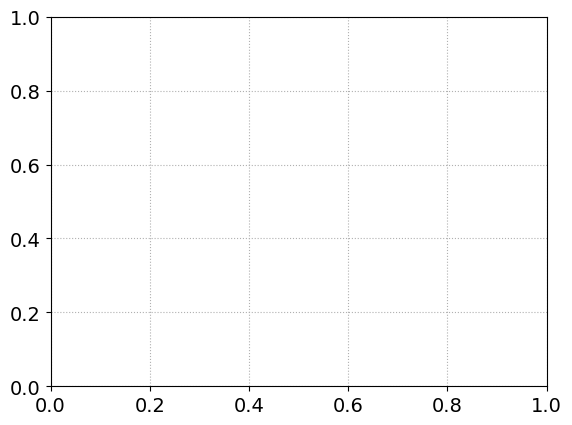

In [ ]:
# summary of response time

labels = collections.OrderedDict({
    "OPTICAL_ATTACK_DETECTOR_CACHE_RESPONSE_TIME_bucket": "Cache",
    "DbscanServing_Detect_histogram_duration_bucket": "Inference",
    "OpticalAttackDetector_DetectAttack_histogram_duration_bucket": "Worker",
})


plt.figure()  # figsize=(6.4, 3.2)
plt.grid(axis="both", ls=":")
lss = ["--", ":", "-"]
for i, (key, label) in enumerate(labels.items()):
    
    x_values = []
    y_values = []
    for v in sorted(cdf[key][load].keys()):
        if v != float("Inf"):
            x_values.append(v)
            y_values.append(np.mean(cdf[key][load][v]))
    
    x_values.append(float("Inf"))
    y_values.append(np.mean(cdf[key][load][float("Inf")]))

    # x_values = np.array(x_values)
    y_values = np.array(y_values)

    # x_values = x_values / x_values.sum()
    y_values = y_values / y_values.sum()
    # y_values = y_values.cumsum()
    print(key, y_values)

    plt.plot(x_values, y_values, label=label, ls=lss[i])

plt.xticks(range(len(x_values)), [x * 1_000 for x in sorted(x_values) if x != float("Inf")] + ["Inf"], rotation=90)
plt.xlabel("Response time [milliseconds]")
plt.xlim([-1, 12.25])
plt.ylabel("CDF of number of requests")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(base_results_folder, latest_folder, "figures", f"cdf_summary_response_time.pdf"))
plt.show()
plt.close()

{'__name__': 'DbscanServing_Detect_histogram_duration_bucket', 'instance': '10.1.19.194:9192', 'job': 'dbscanservingservice', 'le': '+Inf'}
{'__name__': 'DbscanServing_Detect_histogram_duration_bucket', 'instance': '10.1.19.194:9192', 'job': 'dbscanservingservice', 'le': '+Inf'}
{'__name__': 'DbscanServing_Detect_histogram_duration_bucket', 'instance': '10.1.19.194:9192', 'job': 'dbscanservingservice', 'le': '+Inf'}
480 +Inf [1675014193.164, '291']
{'__name__': 'DbscanServing_Detect_histogram_duration_bucket', 'instance': '10.1.19.194:9192', 'job': 'dbscanservingservice', 'le': '+Inf'}
{'__name__': 'DbscanServing_Detect_histogram_duration_bucket', 'instance': '10.1.19.194:9192', 'job': 'dbscanservingservice', 'le': '+Inf'}
1440 +Inf [1675019023.164, '1476']
{'__name__': 'DbscanServing_Detect_histogram_duration_bucket', 'instance': '10.1.19.194:9192', 'job': 'dbscanservingservice', 'le': '+Inf'}
{'__name__': 'DbscanServing_Detect_histogram_duration_bucket', 'instance': '10.1.19.194:9192

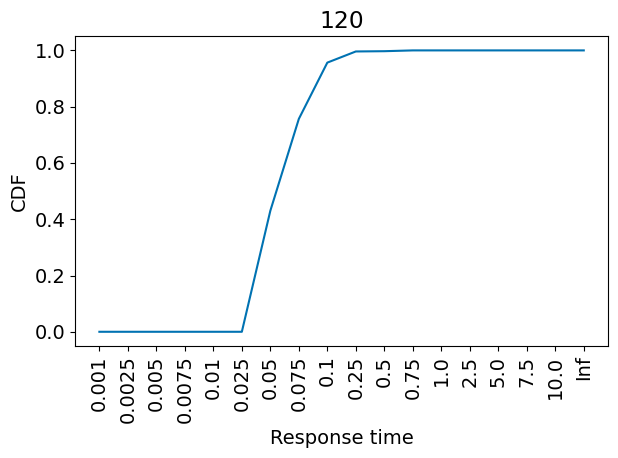

0 0.001
1 0.0025
2 0.005
3 0.0075
4 0.01
5 0.025
6 0.05
7 0.075
8 0.1
9 0.25
10 0.5
11 0.75
12 1.0
13 2.5
14 5.0
15 7.5
16 10.0
17 inf
[   0.            0.            0.            0.            0.
    0.          563.57142857  982.         1274.14285714 1311.71428571
 1312.57142857 1313.28571429 1313.28571429 1313.42857143 1313.42857143
 1313.42857143 1313.42857143 1313.42857143]


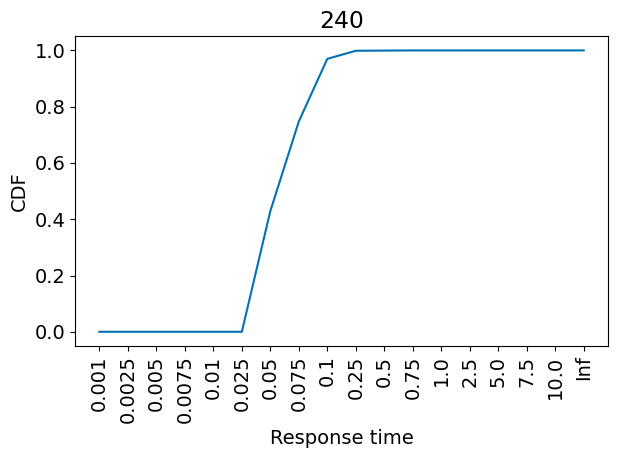

0 0.001
1 0.0025
2 0.005
3 0.0075
4 0.01
5 0.025
6 0.05
7 0.075
8 0.1
9 0.25
10 0.5
11 0.75
12 1.0
13 2.5
14 5.0
15 7.5
16 10.0
17 inf
[   0.            0.            0.            0.            0.
    0.         1243.14285714 2164.85714286 2770.28571429 2856.
 2856.42857143 2857.14285714 2857.42857143 2857.42857143 2857.42857143
 2857.42857143 2857.42857143 2857.42857143]


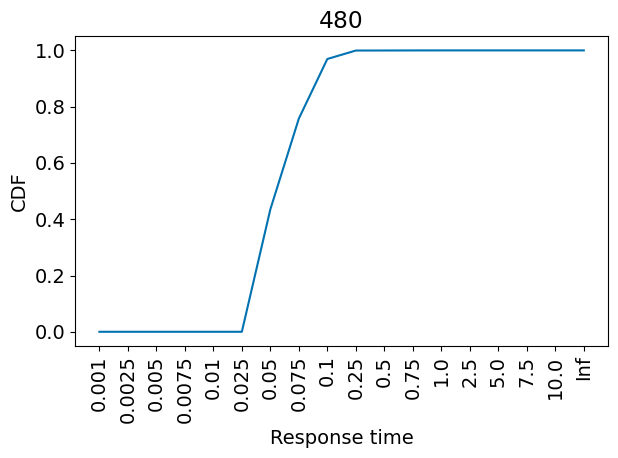

0 0.001
1 0.0025
2 0.005
3 0.0075
4 0.01
5 0.025
6 0.05
7 0.075
8 0.1
9 0.25
10 0.5
11 0.75
12 1.0
13 2.5
14 5.0
15 7.5
16 10.0
17 inf
[   0.       0.       0.       0.       0.       0.    2188.25  3660.875
 4482.625 4628.375 4628.875 4629.75  4629.875 4629.875 4629.875 4629.875
 4629.875 4629.875]


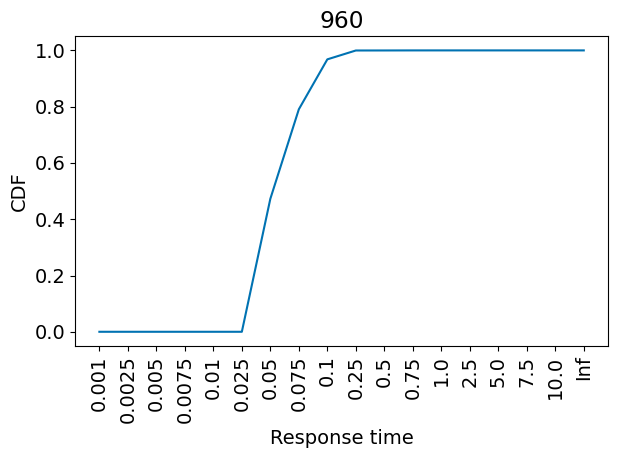

0 0.001
1 0.0025
2 0.005
3 0.0075
4 0.01
5 0.025
6 0.05
7 0.075
8 0.1
9 0.25
10 0.5
11 0.75
12 1.0
13 2.5
14 5.0
15 7.5
16 10.0
17 inf
[   0.     0.     0.     0.     0.     0.  2678.5 4438.8 5344.2 5631.3
 5632.8 5633.5 5633.8 5634.  5634.  5634.  5634.  5634. ]


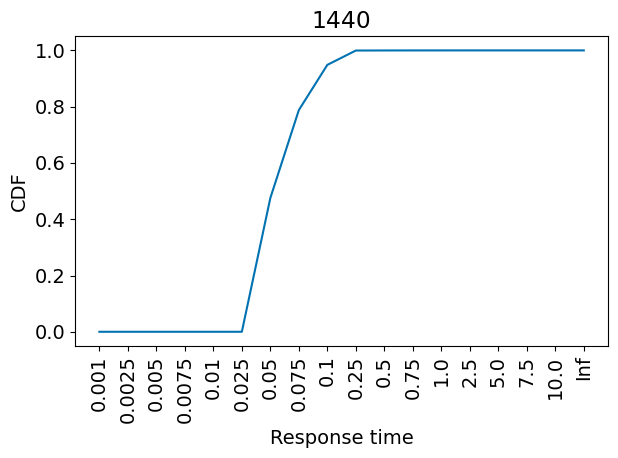

0 0.001
1 0.0025
2 0.005
3 0.0075
4 0.01
5 0.025
6 0.05
7 0.075
8 0.1
9 0.25
10 0.5
11 0.75
12 1.0
13 2.5
14 5.0
15 7.5
16 10.0
17 inf
[   0.      0.      0.      0.      0.      0.   3701.7  6257.55 7536.15
 8274.2  8279.3  8280.1  8280.4  8280.7  8280.7  8280.7  8280.7  8280.7 ]


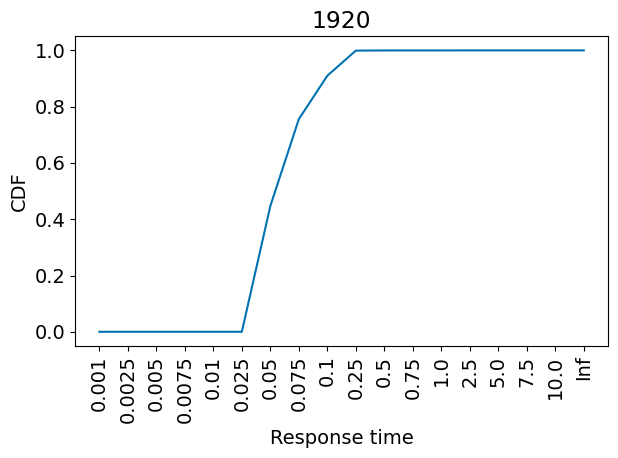

0 0.001
1 0.0025
2 0.005
3 0.0075
4 0.01
5 0.025
6 0.05
7 0.075
8 0.1
9 0.25
10 0.5
11 0.75
12 1.0
13 2.5
14 5.0
15 7.5
16 10.0
17 inf
[   0.      0.      0.      0.      0.      0.   3701.7  6257.55 7536.15
 8274.2  8279.3  8280.1  8280.4  8280.7  8280.7  8280.7  8280.7  8280.7 ]


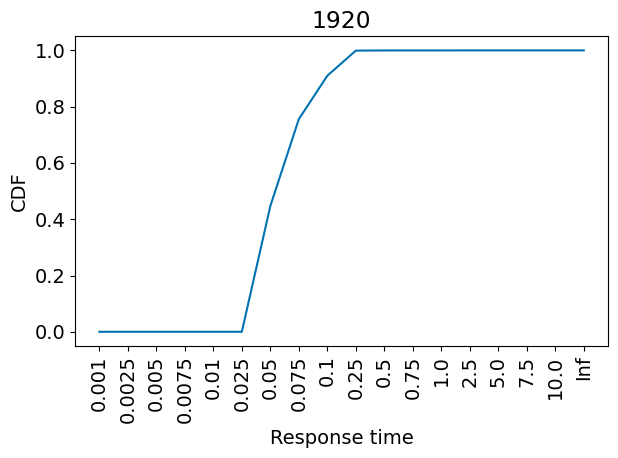

In [ ]:
yesterday = datetime.date.today() - datetime.timedelta(days=1)
duration = '[' + str(yesterday.day) + 'd]'

response = requests.get(
    f"{prometheus_endpoint}/api/v1/query",
    params={
        "query": f"DbscanServing_Detect_histogram_duration_bucket{duration}",
        # "time": time.mktime(yesterday.timetuple())
    }
)

parsed = response.json()
# print("root:", parsed.keys())

# print("data:", parsed["data"].keys())

# print("resulttype:", parsed["data"]["resultType"])

# print("results:", len(parsed["data"]["result"]))

# print("results keys:", parsed["data"]["result"][0].keys())

# print("results metric:", parsed["data"]["result"][0]["metric"])

cdf = {}

for load in loads:
    cdf[load] = {}

for metric in parsed["data"]["result"]:
    # we may have more than one endpoint with this information
    for load, _time in zip(loads, times_services):
        if float(metric["metric"]["le"]) not in cdf[load]:
            cdf[load][float(metric["metric"]["le"])] = []
            print(metric["metric"])
        for value in metric["values"]:
            if _time[0] < value[0] and value[0] < _time[1]:
                print(load, metric["metric"]["le"], value)
                cdf[load][float(metric["metric"]["le"])].append(float(value[1]))
                break # stops the loop over values when the first one is found
    # print("\tmetric:", metric["metric"]["le"], type(metric["metric"]["le"]))
    # print("\tvalue:", metric["values"])

for load in loads:
    probabilities = np.zeros((len(cdf[load].keys()),))
    i = 0
    for key in sorted(cdf[load].keys()):
        if cdf[load][key] == float('Inf'):
            continue
        print(i, key)
        probabilities[i] = np.mean(cdf[load][key])
        i += 1
    probabilities[i-1] = np.mean(cdf[load][float('Inf')])
    print(probabilities)
    probabilities = probabilities / probabilities.max()

    plt.figure()
    plt.title(load)

    plt.plot(range(len(cdf[load].keys())), probabilities)

    plt.xticks(range(len(cdf[load].keys())), [x for x in sorted(cdf[load].keys()) if x != float("Inf")] + ["Inf"], rotation=90)

    plt.xlabel("Response time")
    plt.ylabel("CDF")

    plt.tight_layout()
    plt.show()
    plt.close()
    # for value in parsed["data"]["result"][0]["values"]:
    #     print("\t\t", datetime.datetime.fromtimestamp(value[0]), value[1])


# print("results values:", parsed["data"]["result"])


In [25]:
yesterday = datetime.date.today() - datetime.timedelta(days=1)
duration = '[' + str(yesterday.day) + 'd]'

labels = collections.OrderedDict({
    "OPTICAL_ATTACK_DETECTOR_CACHE_RESPONSE_TIME_bucket": "Cache",
    "OPTICAL_ATTACK_DETECTOR_INFERENCE_RESPONSE_TIME_bucket": "Inference",
    "OPTICAL_ATTACK_DETECTOR_WORKER_RESPONSE_TIME_bucket": "Worker",
})


plt.figure()
for (key, label) in labels.items():

    response = requests.get(
        f"{prometheus_endpoint}/api/v1/query",
        params={
            "query": f"{key}{duration}",
            # "time": time.mktime(yesterday.timetuple())
        }
    )

    parsed = response.json()
    print("root:", parsed.keys())

    # print("data:", parsed["data"].keys())

    # print("resulttype:", parsed["data"]["resultType"])

    # print("results:", len(parsed["data"]["result"]))

    # print("results keys:", parsed["data"]["result"][0].keys())

    # print("results metric:", parsed["data"]["result"][0]["metric"])

    cdf = {}

    for load in loads:
        cdf[load] = {}

    for metric in parsed["data"]["result"]:
        # we may have more than one endpoint with this information
        for load, _time in zip(loads, times_services):
            if float(metric["metric"]["le"]) not in cdf[load]:
                cdf[load][float(metric["metric"]["le"])] = []
                # print(metric["metric"])
            for value in metric["values"]:
                if _time[0] < value[0] and value[0] < _time[1]:
                    # print(load, metric["metric"]["le"], value)
                    cdf[load][float(metric["metric"]["le"])].append(float(value[1]))
                    break # stops the loop over values when the first one is found
        # print("\tmetric:", metric["metric"]["le"], type(metric["metric"]["le"]))
        # print("\tvalue:", metric["values"])

    for load in loads:
        if load != 480: continue
        probabilities = np.zeros((len(cdf[load].keys()),))
        i = 0
        for key in sorted(cdf[load].keys()):
            if cdf[load][key] == float('Inf'):
                continue
            # print(i, key)
            probabilities[i] = np.mean(cdf[load][key])
            i += 1
        probabilities[i-1] = np.mean(cdf[load][float('Inf')])
        # print(probabilities)
        probabilities = probabilities / probabilities.max()

        # plt.title(load)

        plt.plot(range(len(cdf[load].keys())), probabilities, label=label)

plt.xticks(range(len(cdf[load].keys())), [x * 1_000 for x in sorted(cdf[load].keys()) if x != float("Inf")] + ["Inf"], rotation=90)
plt.xlabel("Response time")
plt.ylabel("CDF")
plt.legend(loc=2)
plt.xlim([0.0001, 15])
plt.grid()
plt.tight_layout()
plt.show()
plt.close()
        # for value in parsed["data"]["result"][0]["values"]:
        #     print("\t\t", datetime.datetime.fromtimestamp(value[0]), value[1])


    # print("results values:", parsed["data"]["result"])


root: dict_keys(['status', 'data'])


KeyError: inf

<Figure size 1280x880 with 0 Axes>

In [26]:
data = {}

indices = []

for key, label in labels.items():
    response = requests.get(f"http://localhost:9090/api/v1/query_range?query={key}&start=1675152891.996&end=1675170891.996&step=68")
    parsed = response.json()
    print(key)
    data[key] = {}

    processed_results = {}
    max_value = 0

    for i, result in enumerate(parsed["data"]["result"]):
        if float(result["metric"]["le"]) >= 0.008 and float(result["metric"]["le"]) < 0.025:
            continue
        # print(i, "\t", result["metric"], len(result["values"]), np.sum([float(x[1]) for x in result["values"]]))
        if float(result["metric"]["le"]) not in processed_results:
            processed_results[float(result["metric"]["le"])] = np.sum([float(x[1]) for x in result["values"]])
        else:
            processed_results[float(result["metric"]["le"])] += np.sum([float(x[1]) for x in result["values"]])
        max_value = max(max_value, processed_results[float(result["metric"]["le"])])
        if float(result["metric"]["le"]) * 1_000 not in indices:
            indices.append(float(result["metric"]["le"]) * 1_000)

    for le in sorted([float(x) for x in processed_results.keys()]):
        vec = processed_results[le]
        vec = vec / max_value
        if le == 0.0675:
            le = 0.0625
        processed_results[le] = vec
        print("\t", le * 1_000, vec)
        data[key][le*1_000] = vec
indices.remove(67.5)
indices.sort()
# data["OPTICAL_ATTACK_DETECTOR_INFERENCE_RESPONSE_TIME_bucket"][62.5] = data["OPTICAL_ATTACK_DETECTOR_INFERENCE_RESPONSE_TIME_bucket"][67.5]
# del data["OPTICAL_ATTACK_DETECTOR_INFERENCE_RESPONSE_TIME_bucket"][67.5]

OPTICAL_ATTACK_DETECTOR_CACHE_RESPONSE_TIME_bucket
OPTICAL_ATTACK_DETECTOR_INFERENCE_RESPONSE_TIME_bucket
OPTICAL_ATTACK_DETECTOR_WORKER_RESPONSE_TIME_bucket


ValueError: list.remove(x): x not in list

In [ ]:
print(indices, len(indices))

[0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 7.5, 25.0, 50.0, 62.5, 75.0, 87.5, 100.0, 175.0, 250.0, 375.0, 500.0, 675.0, 750.0, 1000.0, 1750.0, 2500.0, 5000.0, 7500.0, 10000.0, inf] 26


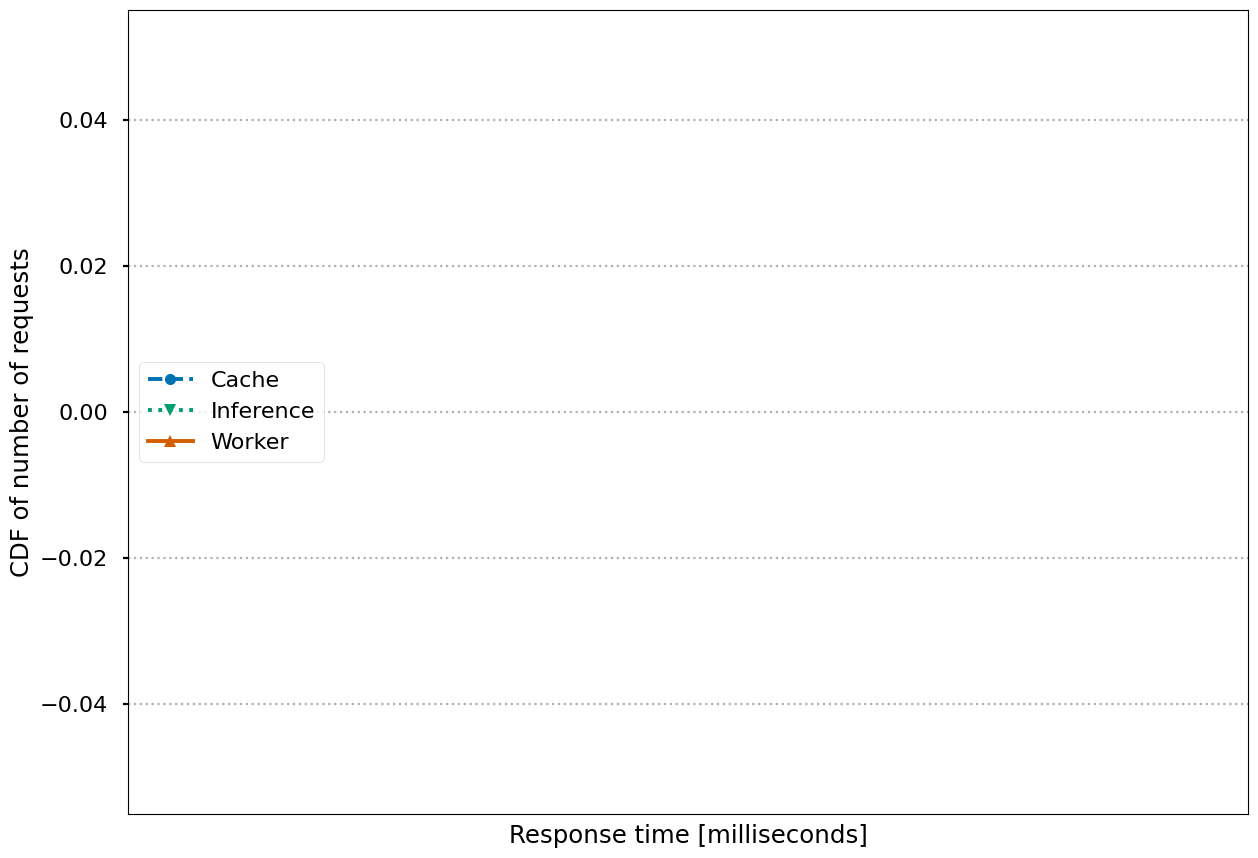

In [27]:
plt.figure()

lss = ["--", ":", "-"]
markers = ['o', 'v', '^']

for idl, (key, label) in enumerate(labels.items()):
    x_values = data[key].keys()
    y_values = data[key].values()
    new_x_values = [indices.index(x) for x in x_values]

    # plt.semilogx(x_values, y_values, label=label)
    plt.plot(new_x_values, y_values, label=label, ls=lss[idl], marker=markers[idl], markeredgecolor='white', markersize=8)
plt.xlabel("Response time [milliseconds]")
plt.ylabel("CDF of number of requests")
plt.xticks(range(len(indices)), indices, rotation=90)
plt.legend(loc=6)
plt.grid(axis="both", ls=":")
plt.xlim([1.5, 14.5])
plt.tight_layout()
plt.savefig(os.path.join(base_results_folder, latest_folder, "figures", f"cdf_summary_response_time.pdf"))
plt.show()